## Transfer Learning with the STL-10 Dataset

This script performs transfer learning on the STL-10 dataset using the VGG-16 network.
We begin by importing the various modules needed, while also specifying the seed and the data directory to be used.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.engine import Model

np.random.seed(42)

DATA_DIR = '/Users/ryankingery/desktop/stl10_binary/'

Using TensorFlow backend.


Next, we load and preprocess the STL-10 data for training.

In [4]:
def import_data(DATA_DIR):
    '''
    Imports STL-10 data 
    Returns as tuple of numpy arrays X_train, y_train, X_test, y_test
    Assumes data are .bin files stored in directory DATA_DIR
    '''
    X_train = np.fromfile(DATA_DIR+'train_X.bin', np.uint8)
    y_train = np.fromfile(DATA_DIR+'train_y.bin', np.uint8)
    X_test = np.fromfile(DATA_DIR+'test_X.bin', np.uint8)
    y_test = np.fromfile(DATA_DIR+'test_y.bin', np.uint8)
    return X_train, y_train, X_test, y_test


def process_data(X_train,y_train,X_test,y_test):
    '''
    Data Processing: 
        Reshape X-arrays to suit the modeling done below. 
        Feature normalization is performed by dividing by X-arrays by 255.
        Labels y are shifted to 0-9 and one-hot encoded as categorical variables.
    Returns: tuple of numpy arrays X_train, y_train, X_test, y_test
    '''
    X_train = X_train.reshape((5000,3,96,96)).transpose(0,2,3,1).astype('float32')
    X_train /= 255
    y_train = y_train.reshape((5000,1))
    y_train -= 1
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    X_test = X_test.reshape((8000,3,96,96)).transpose(0,2,3,1).astype('float32')
    X_test /= 255
    y_test = y_test.reshape((8000,1))
    y_test -= 1
    y_test = keras.utils.to_categorical(y_test, num_classes=10)
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = import_data(DATA_DIR)
X_train, y_train, X_test, y_test = process_data(X_train, y_train, X_test, y_test)

To make sure the images look sensible we plot a few of the images from each training set.

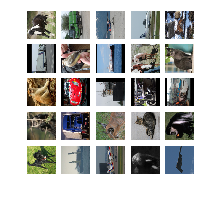

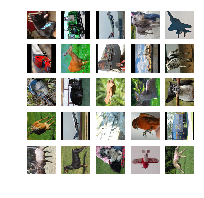

In [5]:
def visualize_data(X):
    '''
    Checks that images still look sensible by plotting 25 random images
    '''
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(X.shape[0]))
            axes1[j,k].set_axis_off()
            axes1[j,k].imshow(X[i:i+1][0])
    plt.show()
    
visualize_data(X_train)
visualize_data(X_test)

Next, we define a function that initializes the network using the VGG-16 weights. As is typical in transfer learning, we strip off the last layer and add in a new dense layer, and train only the weights in that layer while freezing the rest.

In [6]:
def initialize_model(img_width, img_height, channels, num_classes):
    '''
    Initializes and returns model using VGG16 weights with added dense layer
    Trains only added dense layer
    '''
    base_model = VGG16(weights='imagenet', include_top=False, 
                       input_shape=(img_width, img_height, channels))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    pred = Dense(10, activation='sigmoid')(x)
    model = Model(base_model.input, pred)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = initialize_model(96, 96, 3, 10)

Finally, we use the above network to perform the training. We train over 25 epochs with a batch size of 16 using one of Virginia Tech's supercomputing clusters. The results are pasted below. We can see that after 11 epochs the test accuracy has climbed as high as around 73%, which is comparable to the higher accuracies on STL-10 using other models.

In [ ]:
model.fit(X_train, y_train,batch_size=16,epochs=25,shuffle=True,
          verbose=1,validation_data=(X_test, y_test))

In [2]:
#Train on 5000 samples, validate on 8000 samples
#Epoch 1/30
#5000/5000 [==============================] - 200s - loss: 1.4561 - acc: 0.4690 - val_loss: 0.9894 - val_acc: 0.6620
#Epoch 2/30
#5000/5000 [==============================] - 200s - loss: 1.0508 - acc: 0.6354 - val_loss: 0.9809 - val_acc: 0.6529
#Epoch 3/30
#5000/5000 [==============================] - 200s - loss: 0.9252 - acc: 0.6762 - val_loss: 0.8989 - val_acc: 0.6791
#Epoch 4/30
#5000/5000 [==============================] - 200s - loss: 0.8216 - acc: 0.7144 - val_loss: 0.8596 - val_acc: 0.6910
#Epoch 5/30
#5000/5000 [==============================] - 200s - loss: 0.7190 - acc: 0.7466 - val_loss: 0.8836 - val_acc: 0.6940
#Epoch 6/30
#5000/5000 [==============================] - 201s - loss: 0.6613 - acc: 0.7670 - val_loss: 0.8578 - val_acc: 0.7023
#Epoch 7/30
#5000/5000 [==============================] - 201s - loss: 0.5953 - acc: 0.7906 - val_loss: 0.8708 - val_acc: 0.6996
#Epoch 8/30
#5000/5000 [==============================] - 200s - loss: 0.5446 - acc: 0.8040 - val_loss: 0.9464 - val_acc: 0.6906
#Epoch 9/30
#5000/5000 [==============================] - 200s - loss: 0.5018 - acc: 0.8232 - val_loss: 0.8518 - val_acc: 0.7184
#Epoch 10/30
#5000/5000 [==============================] - 200s - loss: 0.4755 - acc: 0.8314 - val_loss: 0.8280 - val_acc: 0.7271
#Epoch 11/30
#5000/5000 [==============================] - 200s - loss: 0.4190 - acc: 0.8478 - val_loss: 0.9071 - val_acc: 0.7123
#Epoch 12/30
#5000/5000 [==============================] - 200s - loss: 0.3971 - acc: 0.8574 - val_loss: 0.9094 - val_acc: 0.7209
#Epoch 13/30
#5000/5000 [==============================] - 200s - loss: 0.3533 - acc: 0.8766 - val_loss: 0.8692 - val_acc: 0.7322
#Epoch 14/30
#5000/5000 [==============================] - 201s - loss: 0.3265 - acc: 0.8854 - val_loss: 0.8773 - val_acc: 0.7261
#Epoch 15/30
#5000/5000 [==============================] - 201s - loss: 0.3073 - acc: 0.8928 - val_loss: 0.8787 - val_acc: 0.7302
#Epoch 16/30
#5000/5000 [==============================] - 201s - loss: 0.2904 - acc: 0.8984 - val_loss: 0.9944 - val_acc: 0.7204
#Epoch 17/30
#5000/5000 [==============================] - 201s - loss: 0.2617 - acc: 0.9070 - val_loss: 0.9153 - val_acc: 0.7315
#Epoch 18/30
#5000/5000 [==============================] - 201s - loss: 0.2485 - acc: 0.9086 - val_loss: 0.9848 - val_acc: 0.7246
#Epoch 19/30
#5000/5000 [==============================] - 201s - loss: 0.2308 - acc: 0.9194 - val_loss: 1.0963 - val_acc: 0.7150
#Epoch 20/30
#5000/5000 [==============================] - 202s - loss: 0.2154 - acc: 0.9258 - val_loss: 1.0423 - val_acc: 0.7282
#Epoch 21/30
#5000/5000 [==============================] - 202s - loss: 0.1879 - acc: 0.9340 - val_loss: 1.0856 - val_acc: 0.7256
#Epoch 22/30
#5000/5000 [==============================] - 201s - loss: 0.1777 - acc: 0.9360 - val_loss: 1.0303 - val_acc: 0.7295
#Epoch 23/30
#5000/5000 [==============================] - 202s - loss: 0.1703 - acc: 0.9366 - val_loss: 1.1438 - val_acc: 0.7155
#Epoch 24/30
#5000/5000 [==============================] - 201s - loss: 0.1738 - acc: 0.9408 - val_loss: 1.0945 - val_acc: 0.7241
#Epoch 25/30
#5000/5000 [==============================] - 201s - loss: 0.1410 - acc: 0.9512 - val_loss: 1.1185 - val_acc: 0.7300